In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import numpy as np
from qiskit import IBMQ, BasicAer, Aer, QuantumRegister, QuantumCircuit
from qiskit.circuit import Parameter, ParameterVector
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import VQE, NumPyEigensolver
from qiskit.aqua.components.optimizers import SLSQP
from qiskit.chemistry import FermionicOperator
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock

/home/chemac/anaconda3/envs/chemproject/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.0) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


# 1. UCCSD

In [2]:
map_type = 'jordan_wigner'

def get_qubit_op(dist):
    driver = PySCFDriver(atom="H .0 .0 .0; H .0 .0 " + str(dist), unit=UnitsType.ANGSTROM, 
                         charge=0, spin=0, basis='sto3g')
    molecule = driver.run()
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    qubitOp = ferOp.mapping(map_type=map_type, threshold=0.00000001)
    shift =  repulsion_energy
    return qubitOp, num_particles, num_spin_orbitals, shift

In [4]:
hf_energies=[]
#Hartree Fock energy is the energy when no optimization is done
optimizer = SLSQP(maxiter=0)
for dist in distances:
    qubitOp, num_particles, num_spin_orbitals, shift = get_qubit_op(dist)
    initial_state = HartreeFock(
        num_spin_orbitals,
        num_particles,
        qubit_mapping=map_type,
        two_qubit_reduction=False
    ) 
    var_form = UCCSD(
        num_orbitals=num_spin_orbitals,
        num_particles=num_particles,
        initial_state=initial_state,
        qubit_mapping=map_type,
        two_qubit_reduction=False
    )
    vqe = VQE(qubitOp, var_form, optimizer)
    vqe_result = np.real(vqe.run(backend)['eigenvalue'] + shift)
    hf_energies.append(vqe_result)

In [3]:
backend = BasicAer.get_backend("statevector_simulator")

#distance from 0.3 to 3.1 focus on 0.7 to 0.8
distances = np.arange(0.3,0.7,0.1)
distances = np.append(distances, np.arange(0.7,0.8,0.005))
distances = np.append(distances, np.arange(0.8,3.1,0.1))
exact_energies = []
UCCSD_energies = []
optimizer = SLSQP(maxiter=5)
for dist in distances:
    qubitOp, num_particles, num_spin_orbitals, shift = get_qubit_op(dist)
    result = NumPyEigensolver(qubitOp).run()
    exact_energies.append(np.real(result.eigenvalues) + shift)
    initial_state = HartreeFock(
        num_spin_orbitals,
        num_particles,
        qubit_mapping=map_type,
        two_qubit_reduction=False
    ) 
    var_form = UCCSD(
        num_orbitals=num_spin_orbitals,
        num_particles=num_particles,
        initial_state=initial_state,
        qubit_mapping=map_type,
        two_qubit_reduction=False
    )
    vqe = VQE(qubitOp, var_form, optimizer)
    vqe_result = np.real(vqe.run(backend)['eigenvalue'] + shift)
    UCCSD_energies.append(vqe_result)
    print("Interatomic Distance:", np.round(dist, 4), "UCCSD Result:", vqe_result, "Exact Energy:", exact_energies[-1][0])
    
print("All energies have been calculated")

Interatomic Distance: 0.3 UCCSD Result: -0.6018037107598917 Exact Energy: -0.6018037107656813
Interatomic Distance: 0.4 UCCSD Result: -0.9141497046155878 Exact Energy: -0.914149704627079
Interatomic Distance: 0.5 UCCSD Result: -1.0551597944480011 Exact Energy: -1.0551597944706186
Interatomic Distance: 0.6 UCCSD Result: -1.1162860068309657 Exact Energy: -1.116286006869541
Interatomic Distance: 0.7 UCCSD Result: -1.1361894540115212 Exact Energy: -1.1361894540659256
Interatomic Distance: 0.705 UCCSD Result: -1.1364956747995507 Exact Energy: -1.136495674854822
Interatomic Distance: 0.71 UCCSD Result: -1.1367503972276471 Exact Energy: -1.1367503972832071
Interatomic Distance: 0.715 UCCSD Result: -1.1369552252005692 Exact Energy: -1.1369552252566222
Interatomic Distance: 0.72 UCCSD Result: -1.1371117150590462 Exact Energy: -1.1371117151154684
Interatomic Distance: 0.725 UCCSD Result: -1.1372213770152055 Exact Energy: -1.1372213770723012
Interatomic Distance: 0.73 UCCSD Result: -1.13728567654

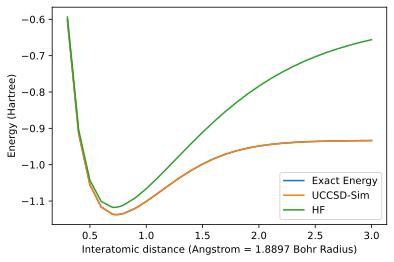

In [5]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, UCCSD_energies, label="UCCSD-Sim")
plt.plot(distances, hf_energies, label="HF")
plt.xlabel('Interatomic distance (Angstrom = 1.8897 Bohr Radius)')
plt.ylabel('Energy (Hartree)')
plt.legend()
plt.show()

# 2. State-Inspired Ansatz

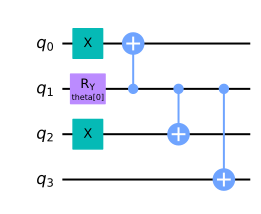

In [6]:
params = ParameterVector('theta', length=1)
easy_qc = QuantumCircuit(4)
easy_qc.x(0)
easy_qc.x(2)
easy_qc.ry(params[0], 1)
easy_qc.cx(1, 0)
easy_qc.cx(1, 2)
easy_qc.cx(1, 3)
easy_qc.draw('mpl')

In [7]:
SI_energies=[]
optimizer = SLSQP(maxiter=5)
for dist in distances:
    qubitOp, num_particles, num_spin_orbitals, shift = get_qubit_op(dist)
    vqe = VQE(operator=qubitOp, optimizer=optimizer, quantum_instance=backend, initial_point=[0])
    vqe.var_form = easy_qc
    result = vqe.compute_minimum_eigenvalue()
    vqe_result = result.eigenvalue.real + shift
    SI_energies.append(vqe_result)

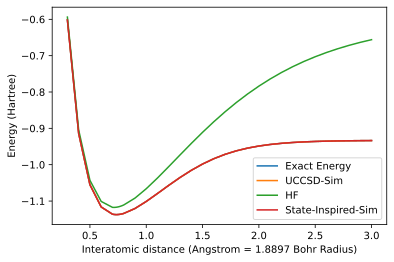

In [8]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, UCCSD_energies, label="UCCSD-Sim")
plt.plot(distances, hf_energies, label="HF")
plt.plot(distances, SI_energies, label="State-Inspired-Sim")
plt.xlabel('Interatomic distance (Angstrom = 1.8897 Bohr Radius)')
plt.ylabel('Energy (Hartree)')
plt.legend()
plt.show()

In [9]:
error_SI = []
for i in range(len(exact_energies)):
    error_SI.append(627.509*abs(exact_energies[i]-SI_energies[i]))

error_UCCSD = []
for i in range(len(exact_energies)):
    error_UCCSD.append(627.509*abs(exact_energies[i]-UCCSD_energies[i]))

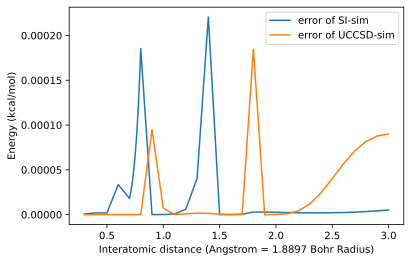

In [10]:
plt.plot(distances, error_SI, label="error of SI-sim")
plt.plot(distances, error_UCCSD, label="error of UCCSD-sim")
plt.xlabel('Interatomic distance (Angstrom = 1.8897 Bohr Radius)')
plt.ylabel('Energy (kcal/mol)')
plt.legend()
plt.show()

# 3. Noise model